In [49]:
import mlrose_hiive as mlrose
import numpy as np
import math
from mlrose_hiive import GeomDecay
import pandas as pd

In [6]:
def bipartite_max(arr):
    assert type(arr) == np.ndarray
    tot = 0
    half_size = len(arr)//2
    tot += np.sum(arr[:half_size] != arr[half_size:])
    tot += np.sum(arr[:half_size-1] != arr[1:half_size])
    return tot


# Initialize custom fitness function object
fitness = mlrose.CustomFitness(bipartite_max)

In [5]:
length = 1000
# get random array of size length
init_state = np.random.randint(2, size=length)

def get_random_result_mean():
    results = []
    for _ in range(10000):
        init_state = np.random.randint(2, size=length)
        results.append(fitness.evaluate(init_state))
    return np.mean(results)

def get_optimal_result():
    return length - 1

get_random_result_mean()
problem = mlrose.DiscreteOpt(length = length, fitness_fn = fitness, max_val = 2)


499.6743

In [17]:
mlrose.genetic_alg(problem, curve=True, pop_size=200, mutation_prob=.1, max_iters=100_000, max_attempts=1000)

(array([1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
        1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
        1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
        0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 

In [96]:
# mlrose.simulated_annealing(
#     problem,
#     max_attempts=10_000,
#     schedule=GeomDecay(init_temp=.5, decay=0.99999, min_temp=0.001),
#     curve=True,
#     max_iters=100_000
# )

mlrose.simulated_annealing(
    problem,
    max_attempts=10_000,
    schedule=GeomDecay(init_temp=.5, decay=0.99999, min_temp=0.001),
    curve=True,
    max_iters=100_000
)

(array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
        0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 

In [98]:
lol = mlrose.random_hill_climb(problem, curve=True, max_attempts=100_000, max_iters=100_000)
lol

(array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
        0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
        1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
        1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
        0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 

In [99]:
lol1 = mlrose.random_hill_climb(problem, curve=True, max_attempts=100_000, max_iters=100_000)
lol2 = mlrose.random_hill_climb(problem, curve=True, max_attempts=100_000, max_iters=100_000)
lol3 = mlrose.random_hill_climb(problem, curve=True, max_attempts=100_000, max_iters=100_000)
raw_results = [lol1, lol2, lol3]

In [100]:
from dataclasses import dataclass

class RunResult:
    def __init__(self, raw_result, eval_groups, time_groups):
        """
        eval_groups is size of groups for evals, so if 1000 then 0-999 is one group, 1000-1999 is another, etc.
        time_groups is same, grouped by milliseconds.
        """
        scores, evals, times = raw_result[-1].T
        scores, evals = scores.astype(int), evals.astype(int)
        times_ms = (times * 1000).astype(int)
        grouped_evals = evals // eval_groups * eval_groups
        grouped_times = times_ms // time_groups * time_groups
        scores = scores
        # make a dataframe that has index of the grouped_evals, value is min of scores, group by evals
        df_evals = pd.DataFrame({"grouped_evals": grouped_evals, "scores": scores})
        self.df_evals = df_evals.groupby("grouped_evals").min()

        df_times = pd.DataFrame({"grouped_times": grouped_times, "scores": scores})
        self.df_times = df_times.groupby("grouped_times").min()

run_results = [RunResult(raw_result, 100, 1) for raw_result in raw_results]

In [103]:
def get_min_median_max(run_results):
    combined_evals = pd.concat([run_result.df_evals for run_result in run_results], axis=1)
    combined_times = pd.concat([run_result.df_times for run_result in run_results], axis=1)
    print(combined_evals)
    agg_eval_df = pd.DataFrame({
        "min": combined_evals.min(axis=1),
        "median": combined_evals.median(axis=1),
        "max": combined_evals.max(axis=1)
    })
    agg_time_df = pd.DataFrame({
        "min": combined_times.min(axis=1),
        "median": combined_times.median(axis=1),
        "max": combined_times.max(axis=1)
    })
    return agg_eval_df, agg_time_df

agg_eval_df, agg_time_df = get_min_median_max(run_results)
agg_eval_df
# agg_time_df


               scores  scores  scores
grouped_evals                        
0                 490     494     484
100               538     537     520
200               571     566     559
300               605     599     603
400               631     629     630
...               ...     ...     ...
99900             905     916     903
100000            905     916     903
100100            905     916     903
100200            905     916     903
100300            905     916     903

[1004 rows x 3 columns]


,min,median,max
grouped_evals,,,
0,484,490.0,494
100,520,537.0,538
200,559,566.0,571
300,599,603.0,605
400,629,630.0,631
...,...,...,...
99900,903,905.0,916
100000,903,905.0,916
100100,903,905.0,916


<Axes: xlabel='grouped_evals'>

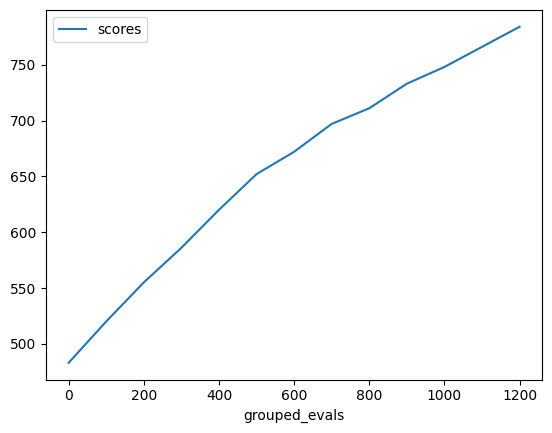

In [48]:
import pandas as pd
eval_groupings = evals // 100
grouped_evals = evals // 100 * 100
# make pandas dataframe, group by eval_groupings, take min of scores
df = pd.DataFrame({'grouped_evals': grouped_evals, 'scores': scores})
df.groupby('grouped_evals').min().plot()

In [47]:
df

,grouped_evals,scores
0,0,483
1,0,484
2,0,485
3,0,486
4,0,487
...,...,...
995,1200,793
996,1200,794
997,1200,794
998,1200,794
